Now we have evaluated the models on the test set we can interpret the results. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from statsmodels.stats.contingency_tables import mcnemar
from scipy import stats
sns.set_theme(style='darkgrid')
sns.set(font_scale = 1.4)

In [3]:
cwd = Path.cwd()
models = cwd / Path('models')
data = cwd / Path('data')
r34_results = data / Path('resnet34_results.csv')
xr50_results = data / Path('xresnet50_results.csv')
xr18_results = data / Path('xresnet18_results.csv')
genus_results = data / Path('genus_model_results.csv')

In [4]:
r34_res = pd.read_csv(r34_results)
xr50_res = pd.read_csv(xr50_results)
xr18_res = pd.read_csv(xr18_results)
g_res = pd.read_csv(genus_results)

Testing significance using Mcnemar's Test

In [102]:
def make_contingency_table(df1, df2):
    table = [[0,0],
             [0,0]]
    comps = [(a,b) for a, b in zip(df1['result'], df2['result'])]
    for c in comps:
        if c == (0,0):
            table[1][1] += 1
        if c == (1,0):
            table[0][1] += 1
        if c == (0,1):
            table[1][0] += 1
        else:
            table[0][0] += 1
    return table

In [114]:
m1m1 = make_contingency_table(r34_res, r34_res)

In [115]:
result_m1m1 = mcnemar(m1m1)
result_m1m1.pvalue

1.0

In [103]:
m1m2 = make_contingency_table(r34_res, xr18_res)

In [112]:
result_m1m2 = mcnemar(m1m2)
result_m1m2.pvalue

8.3007331374909e-99

In [107]:
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

Different proportions of errors (reject H0)


In [113]:
m1m3 = make_contingency_table(r34_res, xr50_res)
result_m1m3 = mcnemar(m1m3)
print(result_m1m3.pvalue)
m2m3 = make_contingency_table(xr18_res, xr50_res)
result_m2m3 = mcnemar(m2m3)
print(result_m2m3.pvalue)

1.98190322692293e-17
4.176298795760821e-46


In [5]:
precision = {'M1': metrics.precision_score(r34_res['actual'], r34_res['cat'],  average='weighted'), 
            'M3': metrics.precision_score(xr50_res['actual'], xr50_res['cat'],  average='weighted'), 
            'M2': metrics.precision_score(xr18_res['actual'], xr18_res['cat'],  average='weighted'), 
            'M4': metrics.precision_score(g_res['actual'], g_res['cat'],  average='weighted')}

/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
precision

{'M1': 0.6638634435974153,
 'M3': 0.6414642216600926,
 'M2': 0.5946329125080002,
 'M4': 0.6099708058138515}

In [7]:
recall = {'M1': metrics.recall_score(r34_res['actual'], r34_res['cat'], average='weighted'), 
            'M3': metrics.recall_score(xr50_res['actual'], xr50_res['cat'], average='weighted'), 
            'M2': metrics.recall_score(xr18_res['actual'], xr18_res['cat'], average='weighted'), 
            'M4': metrics.recall_score(g_res['actual'], g_res['cat'], average='weighted')}

In [8]:
recall

{'M1': 0.6488679428626956,
 'M3': 0.6219026333689631,
 'M2': 0.5800213779030221,
 'M4': 0.5580604411621806}

In [9]:
f1 = {'M1': metrics.f1_score(r34_res['actual'], r34_res['cat'], average='weighted'), 
            'M3': metrics.f1_score(xr50_res['actual'], xr50_res['cat'], average='weighted'), 
            'M2': metrics.f1_score(xr18_res['actual'], xr18_res['cat'], average='weighted'), 
            'M4': metrics.f1_score(g_res['actual'], g_res['cat'], average='weighted')}

In [10]:
f1

{'M1': 0.6436526400849686,
 'M3': 0.6208506180241303,
 'M2': 0.5776836399029217,
 'M4': 0.5606690567737626}

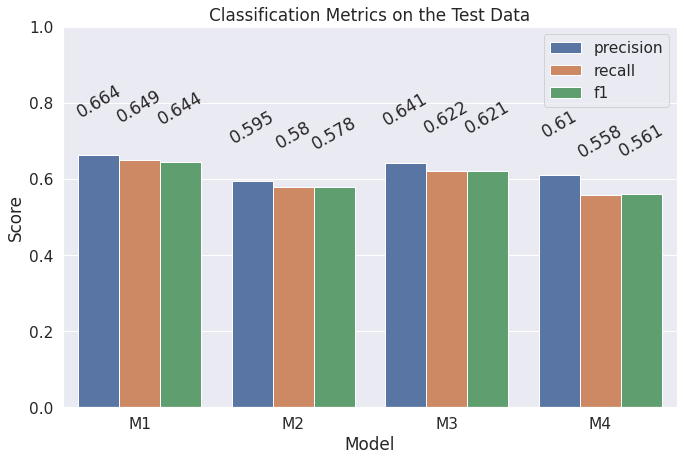

In [11]:
plt.rcParams['figure.figsize'] = (11,7)
d = {
    'x':    ['M1', 'M1',  'M1', 'M2', 'M2', 'M2', 'M3', 'M3', 'M3', 'M4', 'M4', 'M4'],
    'y':    [precision['M1'], recall['M1'], f1['M1'],precision['M2'], recall['M2'], f1['M2'],
            precision['M3'], recall['M3'], f1['M3'], precision['M4'], recall['M4'], f1['M4']],
    'group':[  'precision',  'recall', 'f1', 'precision',  'recall', 'f1', 
            'precision',  'recall', 'f1', 'precision',  'recall', 'f1']
}

ax = sns.barplot(x='x', y='y', hue="group", data=d)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0,1)
plt.title('Classification Metrics on the Test Data')
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+0.1, round(height, 3), ha="center", rotation=30)
plt.show()

In [60]:
print(metrics.confusion_matrix(r34_res['actual'], r34_res['cat']))

[[15  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0 18]]


In [62]:
from sklearn.metrics import classification_report

In [68]:
print(classification_report(r34_res['actual'], r34_res['cat']))

                                      precision    recall  f1-score   support

                 Abortiporus-biennis       0.31      0.48      0.38        31
                   Agaricus-arvensis       0.00      0.00      0.00         7
                   Agaricus-augustus       0.60      0.86      0.71        64
                  Agaricus-bernardii       0.50      0.69      0.58        16
                   Agaricus-bisporus       0.00      0.00      0.00        10
                  Agaricus-bitorquis       0.30      0.50      0.37        12
               Agaricus-californicus       0.17      0.18      0.17        11
                 Agaricus-campestris       0.29      0.25      0.27        20
                  Agaricus-hondensis       0.38      0.26      0.31        19
                   Agaricus-moelleri       0.60      0.43      0.50        14
                 Agaricus-placomyces       0.62      0.42      0.50        12
             Agaricus-subrutilescens       0.88      0.50      

In [69]:
print(classification_report(xr50_res['actual'], xr50_res['cat']))

                                      precision    recall  f1-score   support

                 Abortiporus-biennis       0.33      0.42      0.37        31
                   Agaricus-arvensis       0.00      0.00      0.00         7
                   Agaricus-augustus       0.52      0.73      0.61        64
                  Agaricus-bernardii       0.75      0.56      0.64        16
                   Agaricus-bisporus       0.38      0.30      0.33        10
                  Agaricus-bitorquis       0.47      0.58      0.52        12
               Agaricus-californicus       0.10      0.09      0.10        11
                 Agaricus-campestris       0.47      0.45      0.46        20
                  Agaricus-hondensis       0.47      0.47      0.47        19
                   Agaricus-moelleri       0.40      0.57      0.47        14
                 Agaricus-placomyces       0.80      0.33      0.47        12
             Agaricus-subrutilescens       0.83      0.36      

In [70]:
print(classification_report(xr18_res['actual'], xr18_res['cat']))

                                      precision    recall  f1-score   support

                 Abortiporus-biennis       0.31      0.32      0.32        31
                   Agaricus-arvensis       0.00      0.00      0.00         7
                   Agaricus-augustus       0.55      0.70      0.62        64
                  Agaricus-bernardii       0.53      0.62      0.57        16
                   Agaricus-bisporus       0.00      0.00      0.00        10
                  Agaricus-bitorquis       0.26      0.67      0.37        12
               Agaricus-californicus       0.20      0.18      0.19        11
                 Agaricus-campestris       0.25      0.20      0.22        20
                  Agaricus-hondensis       0.47      0.42      0.44        19
                   Agaricus-moelleri       0.35      0.57      0.43        14
                 Agaricus-placomyces       0.80      0.33      0.47        12
             Agaricus-subrutilescens       0.56      0.36      

In [71]:
print(classification_report(g_res['actual'], g_res['cat']))

                                      precision    recall  f1-score   support

                 Abortiporus-biennis       0.58      0.34      0.43        32
                   Agaricus-arvensis       0.00      0.00      0.00         7
                   Agaricus-augustus       0.44      0.70      0.54        64
                  Agaricus-bernardii       0.44      0.50      0.47        16
                   Agaricus-bisporus       0.14      0.10      0.12        10
                  Agaricus-bitorquis       0.18      0.36      0.24        11
               Agaricus-californicus       0.12      0.18      0.14        11
                 Agaricus-campestris       0.30      0.40      0.34        20
                  Agaricus-hondensis       0.29      0.26      0.28        19
                   Agaricus-moelleri       0.35      0.43      0.39        14
                 Agaricus-placomyces       0.44      0.33      0.38        12
             Agaricus-subrutilescens       0.35      0.50      

In [ ]:
stats.ttest_ind()